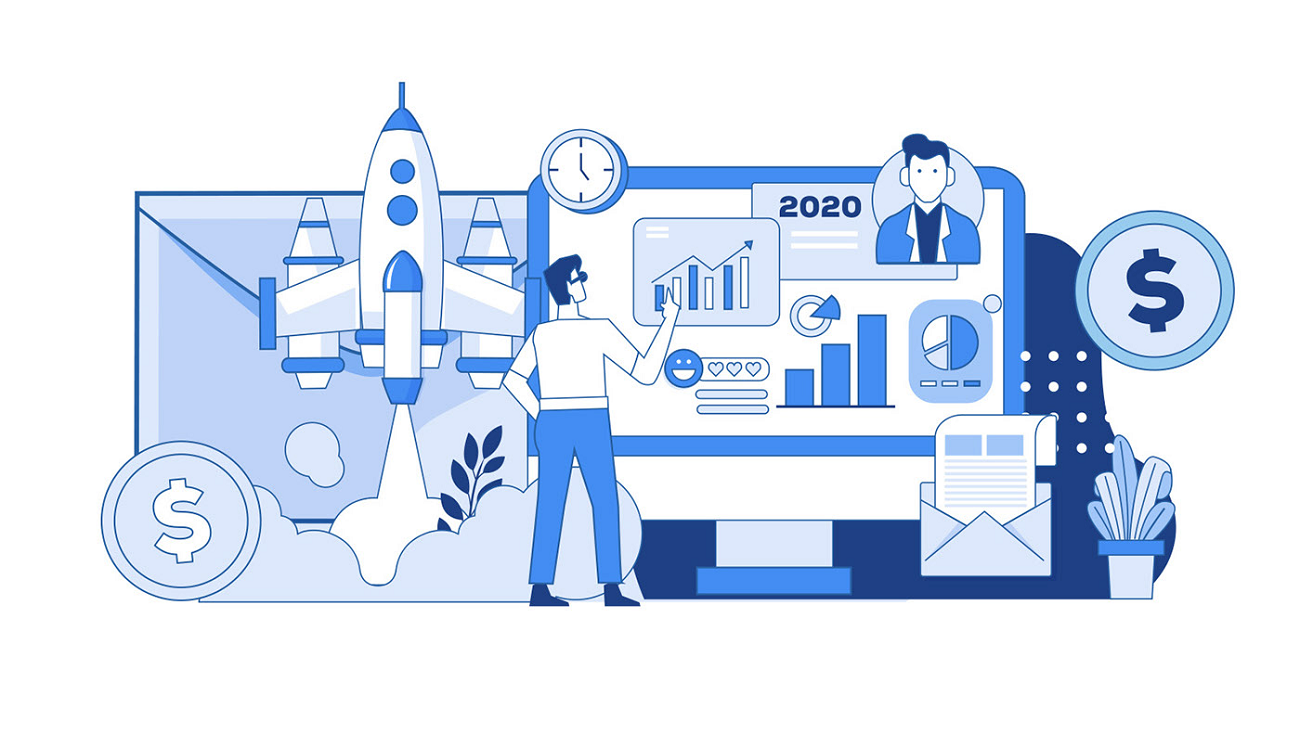

# 1. Problema de negócio

Para planejar o seu orçamento, uma rede de 1115 precisa prever as suas vendas para os próximos 150 dias. Possuindo um dataset referente às vendas e outro dataset referente a características das lojas, utilizaremos o algoritmo do Facebook Prophet para fazer essa previsão.

A ilustração de capa é de Unblast.

# 2. Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

sns.set()

%matplotlib inline

# 3. Importação dos dados

## Dados das vendas

In [2]:
sales_train_df = pd.read_csv('/content/train.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
sales_train_df.shape

(1017209, 9)

In [4]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


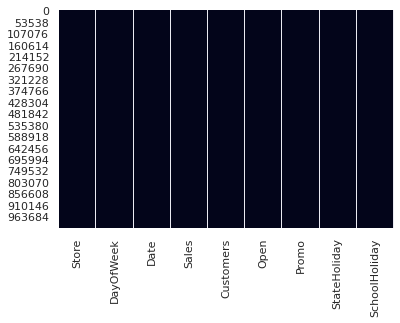

In [5]:
sns.heatmap(sales_train_df.isnull(), cbar=False);

In [6]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


## Dados das lojas

In [7]:
store_info_df = pd.read_csv('/content/store.csv')

In [8]:
store_info_df.shape

(1115, 10)

In [9]:
store_info_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
store_info_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


## 4. Análise exploratória dos dados

## Dados das vendas

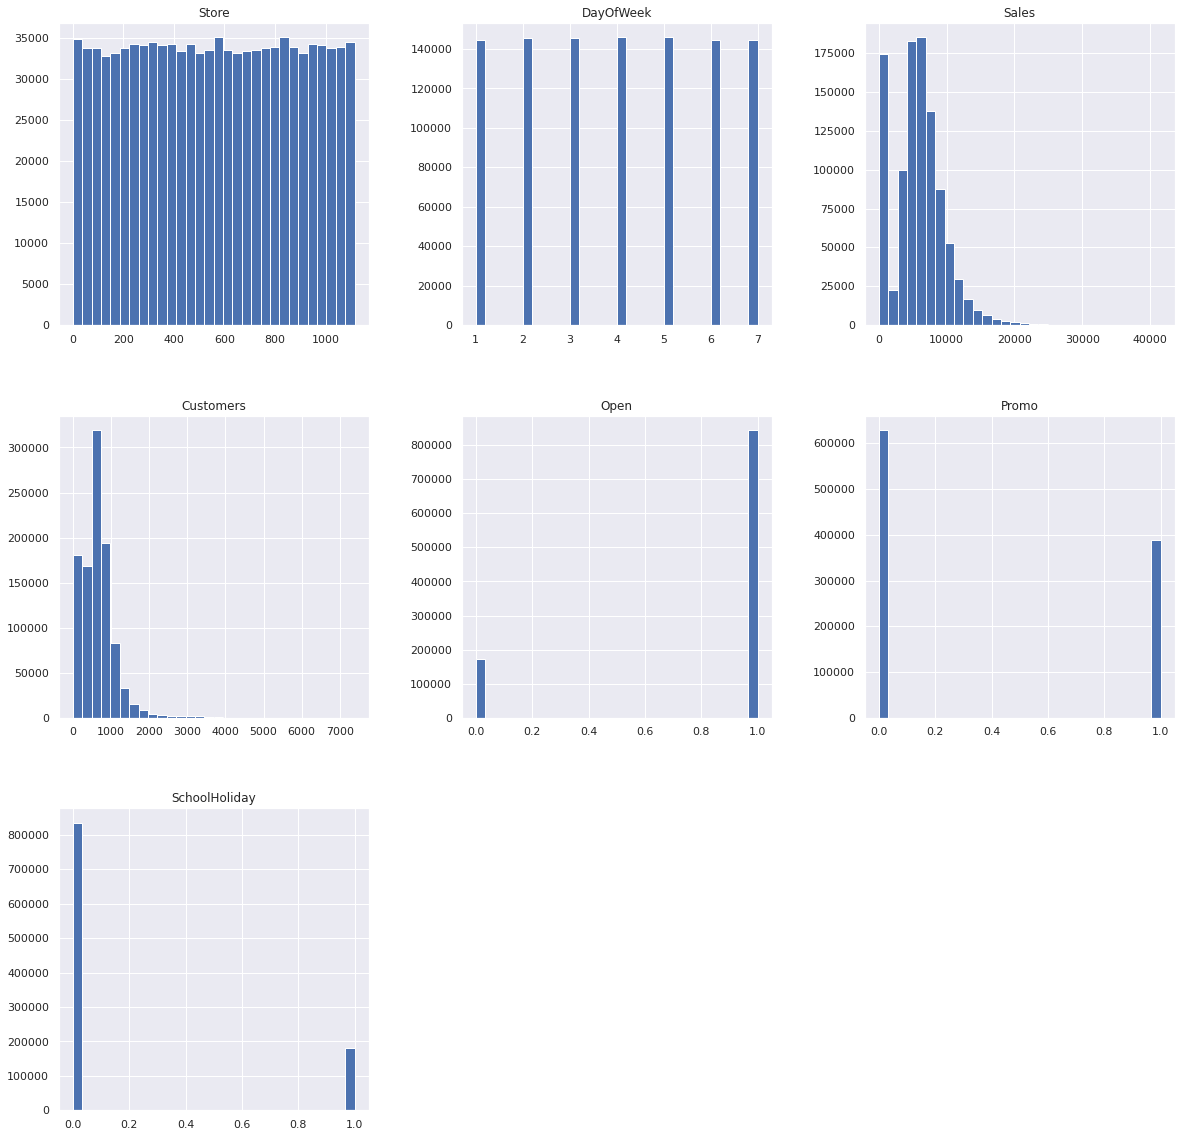

In [11]:
sales_train_df.hist(bins=30, figsize=(20,20), color='b');

O número das vendas quando as lojas estavam fechadas é 0, e esse valor joga a média de vendas para baixo, portanto faz-se necessário analisar apenas os dados de quando as lojas estavam funcionando normalmente.

In [12]:
sales_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [13]:
sales_train_df.drop(['Open'], axis=1,inplace=True)

In [14]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


## Dados das lojas

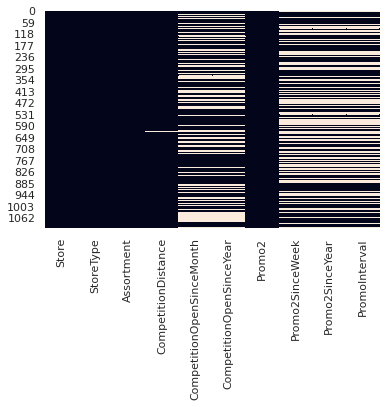

In [15]:
# verificando os dados faltantes

sns.heatmap(store_info_df.isnull(), cbar=False);

In [16]:
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [17]:
# preenchendo os dados faltantes com 0

str_cols = ['Promo2SinceWeek', 'Promo2SinceYear','PromoInterval','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']

for str in str_cols:
    store_info_df[str].fillna(0, inplace=True)

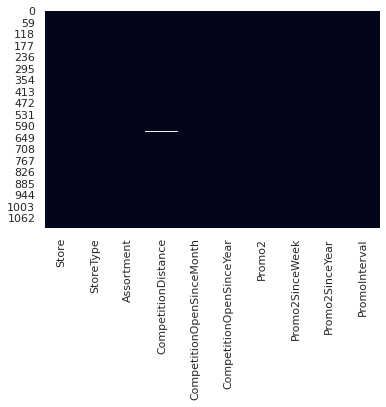

In [18]:
sns.heatmap(store_info_df.isnull(), cbar=False)

In [19]:
# para o atributo 'competition distance', preencheremos os valores faltantes com a média

store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(), inplace = True)

In [20]:
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


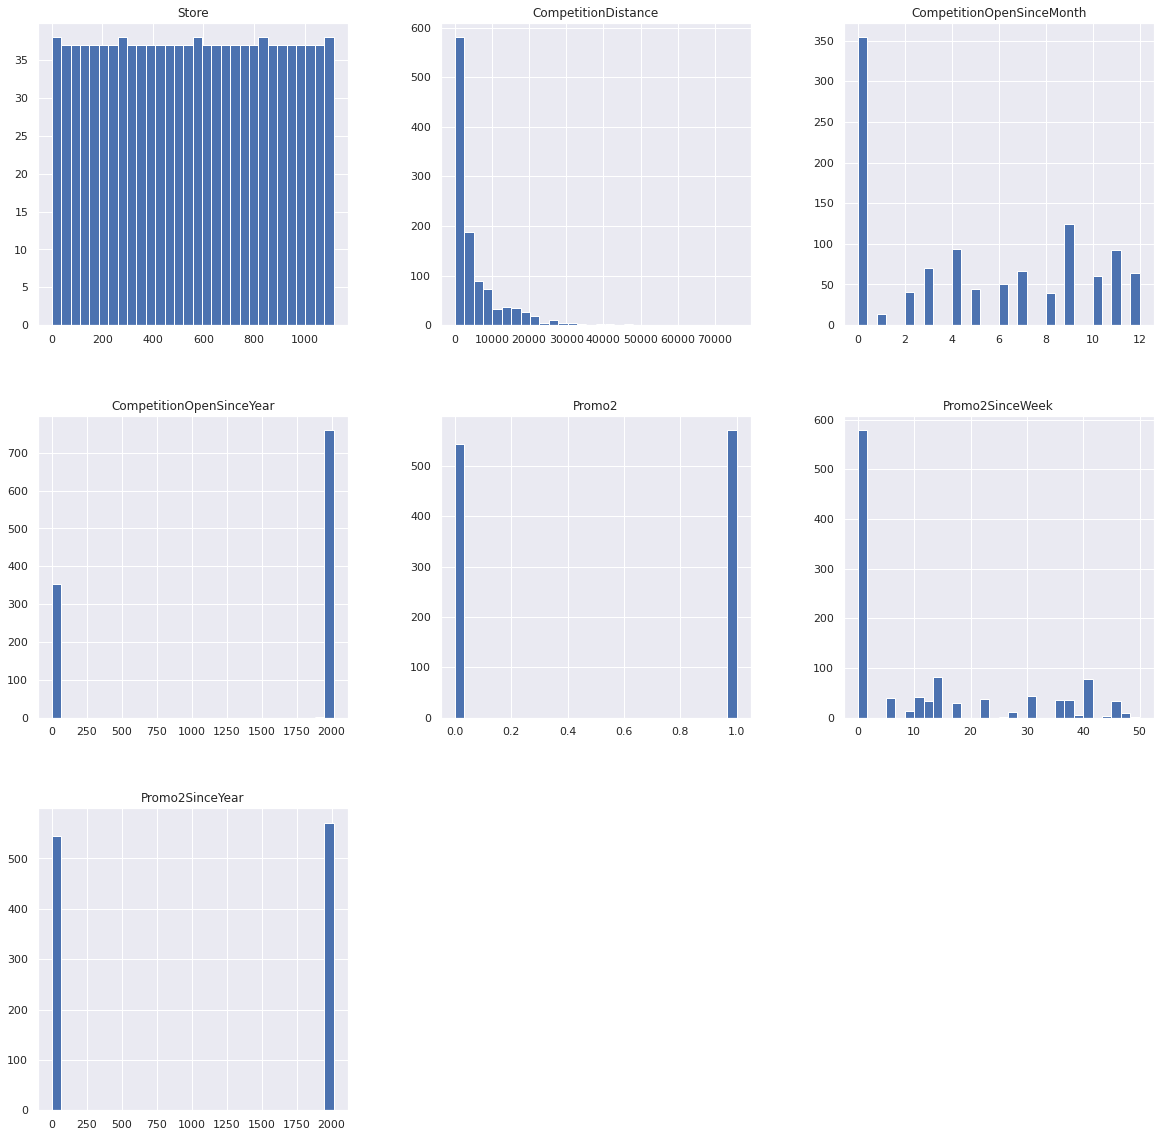

In [21]:
store_info_df.hist(bins=30, figsize=(20,20), color='b');

## Dados unidos (vendas + lojas)

Após o tratamento dos dados dos dois datasets, iremos fazer um merge para que se tornem um só.

In [22]:
sales_train_all_df = pd.merge(sales_train_df, store_info_df, how='inner', on='Store')

In [23]:
sales_train_all_df.shape

(844392, 17)

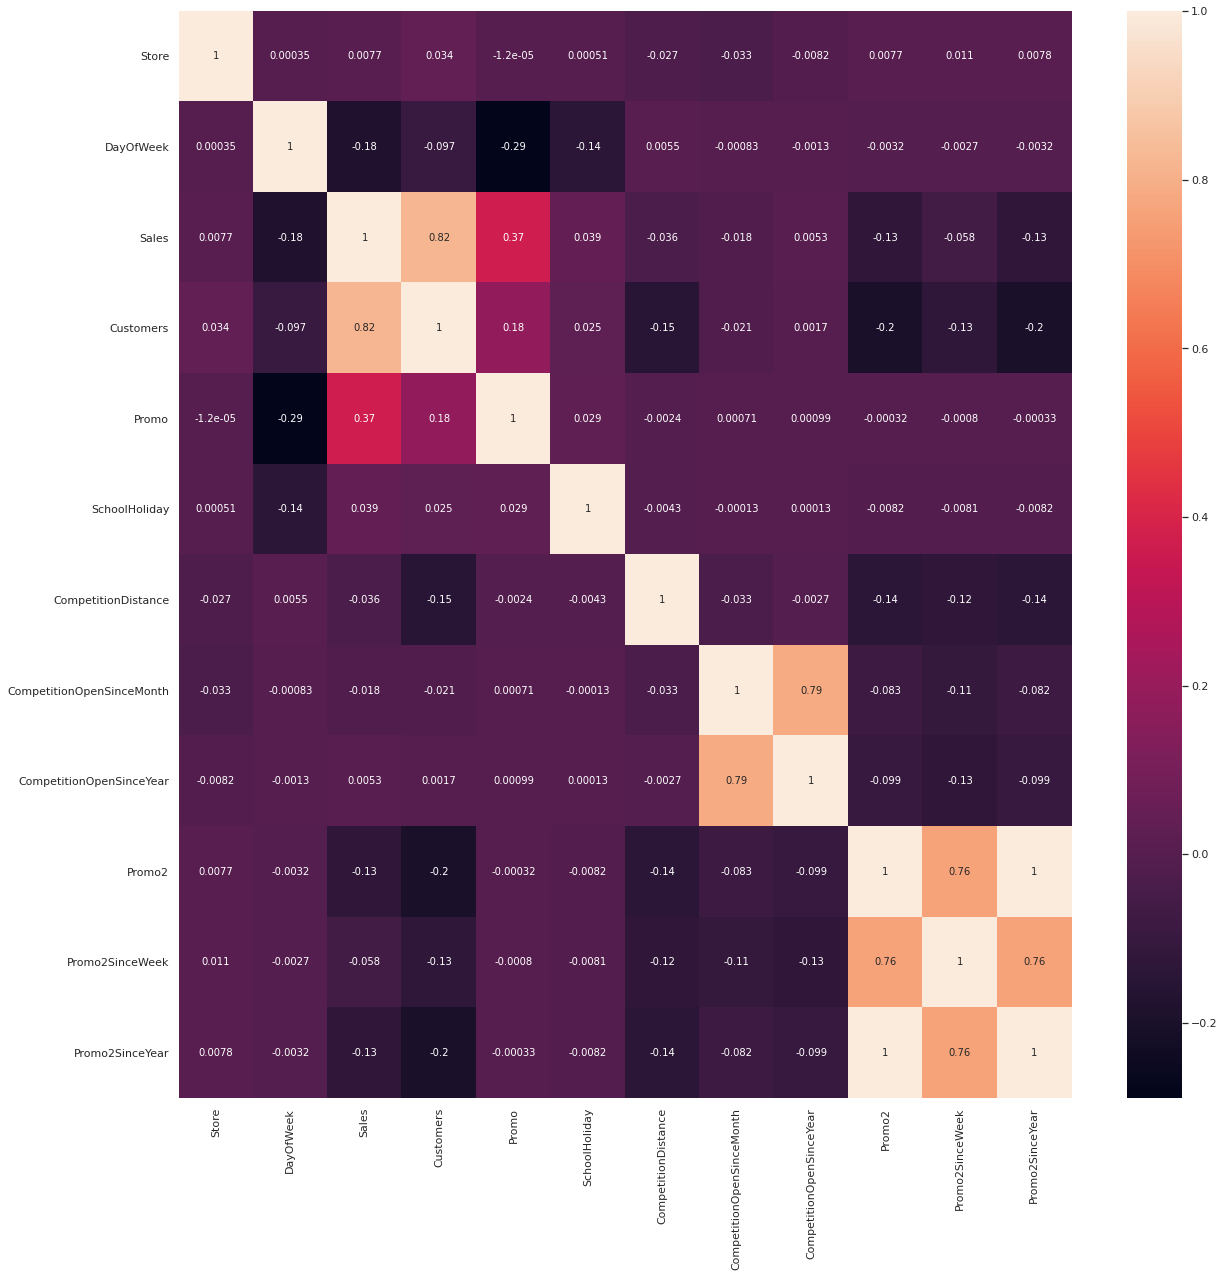

In [24]:
correlations = sales_train_all_df.corr()
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(correlations, annot=True);

In [25]:
correlations = sales_train_all_df.corr()['Sales'].sort_values()
correlations

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

Como o objetivo é identificar os atributos que influenciam as vendas, fez-se uma 'correlations' específica para isso. Interessante verificar que a Promo2 e o DayOfWeek não possuem influencia no faturamento da loja.

In [26]:
# dividindo em ano, mês e dia

sales_train_all_df['Year'] = pd.DatetimeIndex(sales_train_all_df['Date']).year
sales_train_all_df['Month'] = pd.DatetimeIndex(sales_train_all_df['Date']).month
sales_train_all_df['Day'] = pd.DatetimeIndex(sales_train_all_df['Date']).day

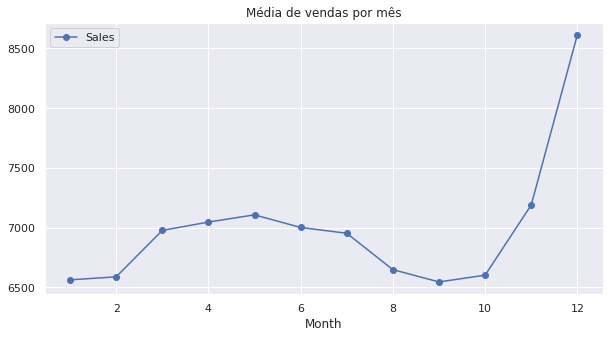

In [27]:
# vendas por mês

axis = sales_train_all_df.groupby('Month')[['Sales']].mean().plot(figsize=(10,5), marker='o')
axis.set_title('Média de vendas por mês');

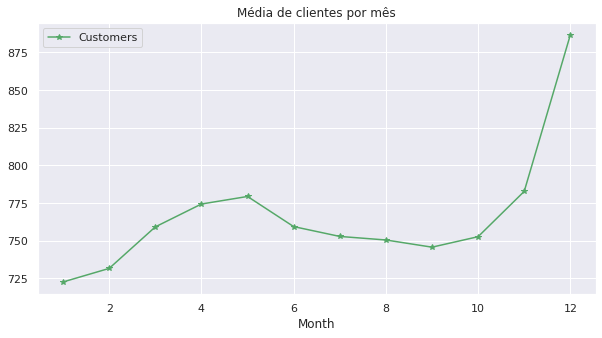

In [28]:
# clientes por mês

axis = sales_train_all_df.groupby('Month')[['Customers']].mean().plot(figsize=(10,5), marker='*', color='g')
axis.set_title('Média de clientes por mês');

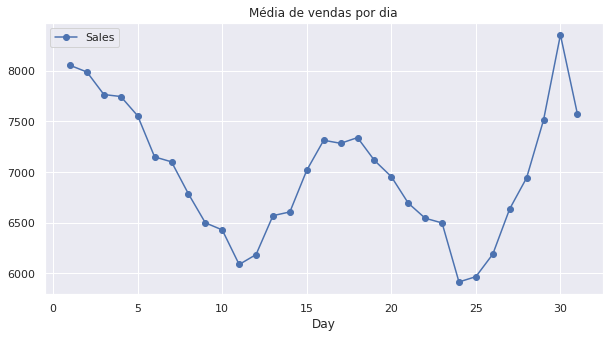

In [29]:
# vendas por dia

axis = sales_train_all_df.groupby('Day')[['Sales']].mean().plot(figsize=(10,5), marker='o')
axis.set_title('Média de vendas por dia');

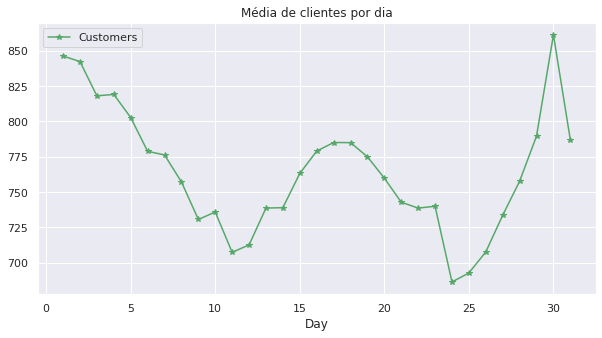

In [30]:
# clientes por dia

axis = sales_train_all_df.groupby('Day')[['Customers']].mean().plot(figsize=(10,5), marker='*', color='g')
axis.set_title('Média de clientes por dia');

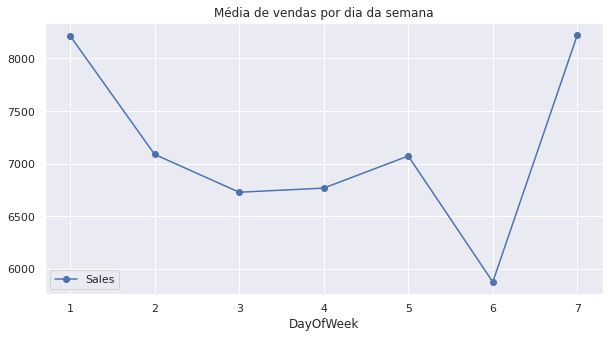

In [31]:
# vendas por dia da semana

axis = sales_train_all_df.groupby('DayOfWeek')[['Sales']].mean().plot(figsize=(10,5), marker='o')
axis.set_title('Média de vendas por dia da semana');

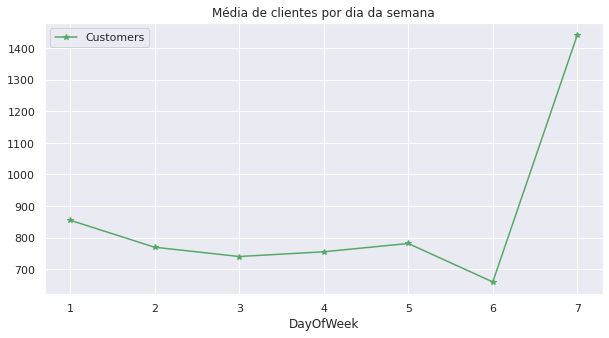

In [32]:
# clientes por dia da semana

axis = sales_train_all_df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize=(10,5), marker='*', color='g')
axis.set_title('Média de clientes por dia da semana');

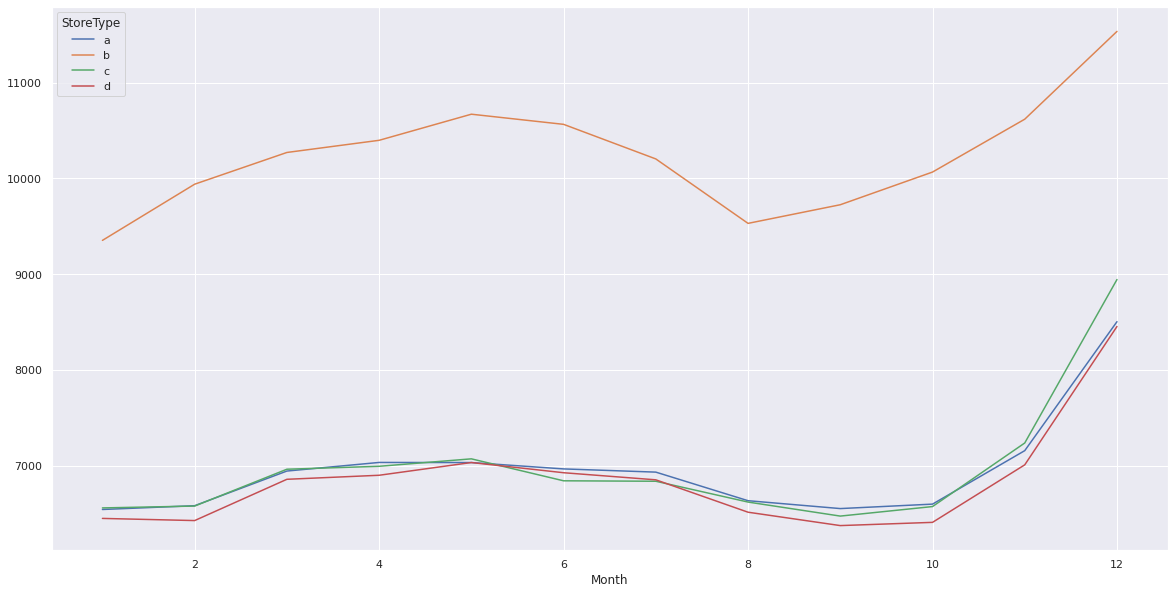

In [33]:
fig, ax = plt.subplots(figsize=(20,10))
sales_train_all_df.groupby(['Month', 'StoreType']).mean()['Sales'].unstack().plot(ax=ax);

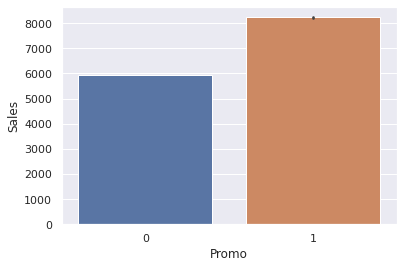

In [34]:
sns.barplot(x='Promo',y='Sales', data=sales_train_all_df)

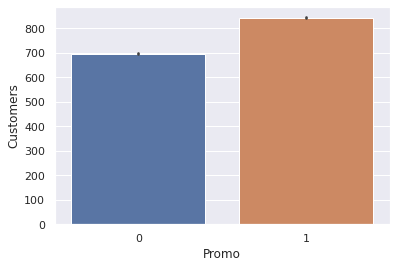

In [35]:
sns.barplot(x='Promo',y='Customers', data=sales_train_all_df)

## 5. Aplicação do Facebook Prophet

In [36]:
!pip install fbprophet

In [37]:
from fbprophet import Prophet

In [38]:
# como existem muitas lojas, iremos fazer previsões para lojas específicas 
# renomear colunas antes de aplicar o facebook prophet
# date: ds
# sales: y

def sales_prediction(store_id, sales_df, periods):
  sales_df = sales_df[sales_df['Store']==store_id]
  sales_df = sales_df[['Date','Sales']].rename(columns={'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values(by='ds')

  model = Prophet()
  model.fit(sales_df)

  future = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)

  figure1 = model.plot(forecast,xlabel= 'Data', ylabel='Vendas')
  figure2 = model.plot_components(forecast)

  return sales_df, forecast


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


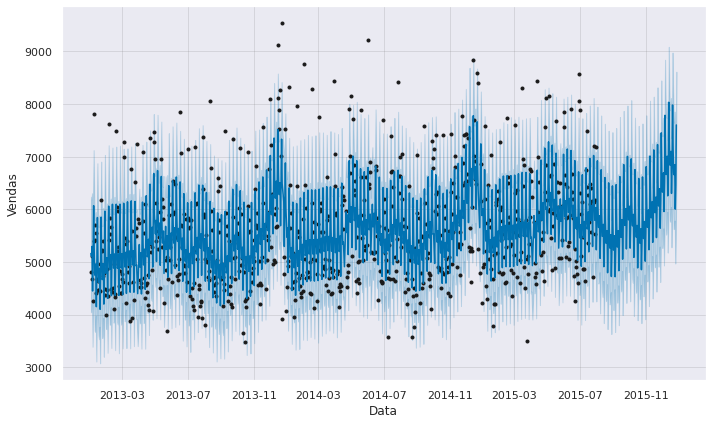

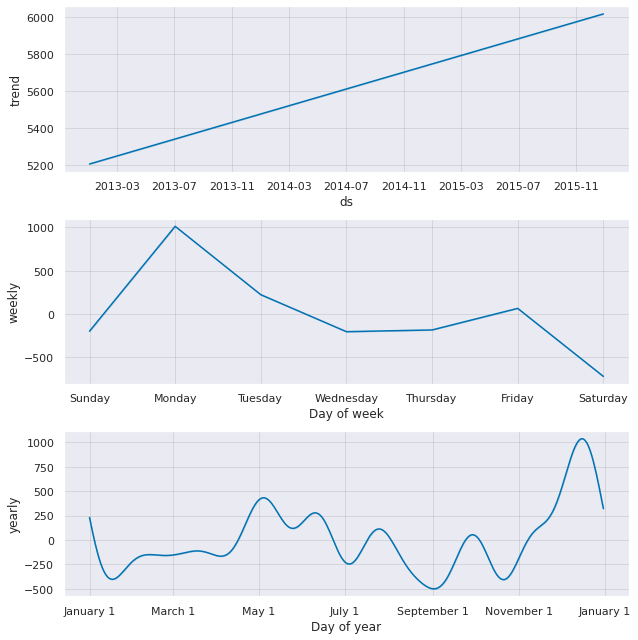

In [39]:
df_origin, df_prediction = sales_prediction(10, sales_train_all_df, 150)

In [40]:
df_origin.shape, df_prediction.shape

((784, 2), (934, 19))

Como a previsão se refere aos próximos 150 dias, criamos um arquivo com os dados de vendas desse período.

In [41]:
df_prediction.tail(150).to_excel('previsoes_vendas.xlsx')

# 5.1 Treinamento do modelo inserindo feriados

   - StateHoliday: Normalmente todas as lojas estão fechadas nesses feriados. As escolas estão fechadas nesses feriados e nos finais de semana. Legenda: a = public holiday, b = Páscoa, c = Natal, 0 = Nenhum feriado
   - SchoolHoliday: indica se a loja foi afetada pelo feriado escolar


   Esse novo treinamento é necessário para que o algoritmo não descarte a sazonalidade de vendas nos feriados como se fossem outliers.

In [42]:
def sales_prediction(store_id, sales_df, holidays, periods):
  sales_df = sales_df[sales_df['Store'] == store_id]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
  sales_df = sales_df.sort_values(by = 'ds')

  model = Prophet(holidays=holidays)
  model.fit(sales_df)
  future = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)
  figure1 = model.plot(forecast, xlabel = 'Data', ylabel = 'Vendas')
  figure2 = model.plot_components(forecast)

  return sales_df, forecast

#### Criando um dataframe específico para feriados

In [43]:


school_holidays = sales_train_all_df[sales_train_all_df['SchoolHoliday']==1].loc[:, 'Date'].values
school_holidays.shape

(163457,)

In [44]:
len(np.unique(school_holidays))

477

In [45]:
state_holidays = sales_train_all_df[(sales_train_all_df['StateHoliday']=='a') |
                            (sales_train_all_df['StateHoliday']=='b') |
                            (sales_train_all_df['StateHoliday']=='c')].loc[:,'Date'].values

In [46]:
len(np.unique(state_holidays))

35

In [47]:
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                               'holiday': 'state_holiday'})

state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
905,2013-04-01,state_holiday
906,2013-08-15,state_holiday
907,2015-06-04,state_holiday
908,2014-06-19,state_holiday


In [48]:
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                               'holiday': 'school_holiday'})

school_holidays

,ds,holiday
0,2015-07-31,school_holiday
1,2015-07-30,school_holiday
2,2015-07-29,school_holiday
3,2015-07-28,school_holiday
4,2015-07-27,school_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


In [49]:
# concatenando os dataframes

school_state_holidays = pd.concat((state_holidays,school_holidays))

school_state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


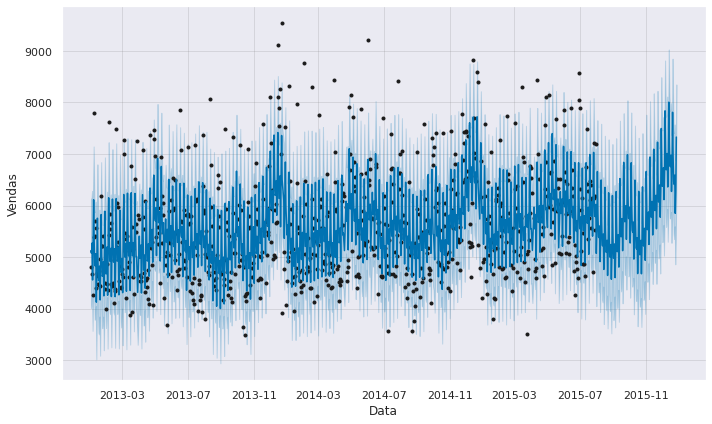

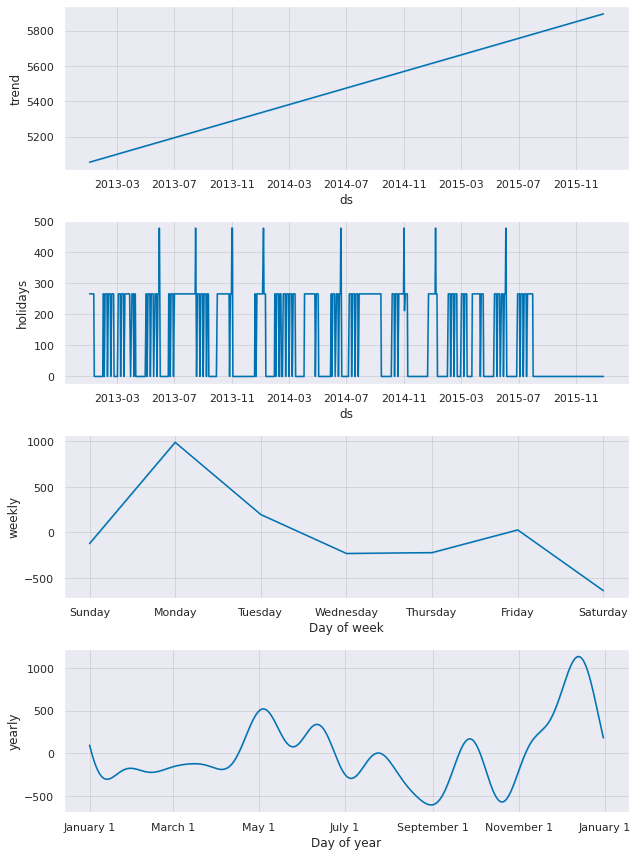

In [50]:
df_original, df_prediction = sales_prediction(10, sales_train_all_df,school_state_holidays,150)

In [51]:
df_prediction.tail(150).to_excel('previsoes_vendas_com_feriados.xlsx')
df_prediction.tail(150)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,school_holiday,school_holiday_lower,school_holiday_upper,state_holiday,state_holiday_lower,state_holiday_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
784,2015-08-01,5780.431380,4049.295601,6188.241510,5780.431380,5780.431380,-709.577962,-709.577962,-709.577962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-639.832929,-639.832929,-639.832929,-69.745034,-69.745034,-69.745034,0.0,0.0,0.0,5070.853417
785,2015-08-02,5781.202722,4514.649082,6638.687937,5781.202722,5781.202722,-212.763686,-212.763686,-212.763686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-122.417415,-122.417415,-122.417415,-90.346272,-90.346272,-90.346272,0.0,0.0,0.0,5568.439035
786,2015-08-03,5781.974064,5697.822795,7655.926765,5781.974064,5781.974064,878.153090,878.153090,878.153090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,990.574123,990.574123,990.574123,-112.421032,-112.421032,-112.421032,0.0,0.0,0.0,6660.127154
787,2015-08-04,5782.745406,4803.847231,6859.694069,5782.745406,5782.745406,61.076081,61.076081,61.076081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196.697375,196.697375,196.697375,-135.621294,-135.621294,-135.621294,0.0,0.0,0.0,5843.821487
788,2015-08-05,5783.516748,4320.483922,6353.551701,5783.516748,5783.516748,-390.769531,-390.769531,-390.769531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-231.157861,-231.157861,-231.157861,-159.611670,-159.611670,-159.611670,0.0,0.0,0.0,5392.747217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929,2015-12-24,5892.275984,5349.560513,7408.417587,5892.274446,5892.277412,519.232825,519.232825,519.232825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-221.725581,-221.725581,-221.725581,740.958406,740.958406,740.958406,0.0,0.0,0.0,6411.508809
930,2015-12-25,5893.047326,5598.143142,7573.371074,5893.045774,5893.048767,697.470398,697.470398,697.470398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.862288,27.862288,27.862288,669.608109,669.608109,669.608109,0.0,0.0,0.0,6590.517724
931,2015-12-26,5893.818668,4860.349017,6887.530597,5893.817096,5893.820128,-44.325651,-44.325651,-44.325651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-639.832929,-639.832929,-639.832929,595.507278,595.507278,595.507278,0.0,0.0,0.0,5849.493017
932,2015-12-27,5894.590010,5327.827772,7278.016432,5894.588420,5894.591496,397.226126,397.226126,397.226126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-122.417415,-122.417415,-122.417415,519.643541,519.643541,519.643541,0.0,0.0,0.0,6291.816137
